### Import & Data load

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
import os

_dir = '_19'
_file_ls = os.listdir(_dir)
_file_ls

freez2 = pd.read_csv(os.path.join(_dir, _file_ls[3]))
suth2 = pd.read_csv(os.path.join(_dir, _file_ls[5]))
freez3 = pd.read_csv(os.path.join(_dir, _file_ls[-3]))
suth3 = pd.read_csv(os.path.join(_dir, _file_ls[-1]))

freez2.columns
freez2.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
       'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
       'operation', 'run_time', 'insert_dt']

suth2.columns
suth2.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
       'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
       'insert_dt']

freez3.columns
freez3.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
       'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
       'operation', 'run_time', 'insert_dt']

suth3.columns
suth3.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
       'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
       'insert_dt']


In [27]:
# No. 16
sensor_id = [290, 293, 296, 299]
freezer_id = [308,314,320,326]

df_sensor = pd.DataFrame()
df_freezer = pd.DataFrame()

for elem in sensor_id:
    df_sensor = pd.concat([df_sensor, suth2[suth2['sensor_id'] == elem]])
    print("sensor id {}의 데이터 개수: {}".format(elem, len(suth2[suth2['sensor_id'] == elem])))
for elem in freezer_id:
    df_freezer = pd.concat([df_freezer, freez2[freez2['freezer_id'] == elem]])
    print("freezer id {}의 데이터 개수: {}".format(elem, len(df_freezer[df_freezer['freezer_id'] == elem])))


print(df_sensor['sensor_id'].unique())
print(df_freezer['freezer_id'].unique())

sensor id 290의 데이터 개수: 80181
sensor id 293의 데이터 개수: 80181
sensor id 296의 데이터 개수: 80174
sensor id 299의 데이터 개수: 80174
freezer id 308의 데이터 개수: 81099
freezer id 314의 데이터 개수: 81099
freezer id 320의 데이터 개수: 81099
freezer id 326의 데이터 개수: 81099
[290 293 296 299]
[308 314 320 326]


# 2월

### type 변환 및 sorting

In [31]:
df_freezer = df_freezer.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)
df_sensor = df_sensor.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)

df_freezer['gw_time'] = pd.to_datetime(df_freezer['gw_time'])
df_sensor['gw_time'] = pd.to_datetime(df_sensor['gw_time'])


# Column 별 데이터 확인
### 1. freezer -> 항상 가동 중일 가능성 있음
- freezer_id       : [308, 314, 320, 326]
- gw_time          : 2월 1일 ~ 2월 28일
- status           : 모든 id의 전 구간 값이 1 (범주형 변수로 예상, 추가적인 설명 필요함)
- fan_run          : 각 id의 fan 가동 여부(예상), 각 센서별 fan이 일정주기로 약 10분간 shutdown, 이외에는 항상 켜져있음
- fan_trip         : 모든 id의 전 구간 값이 0 
- freez_run        : 0,1의 범주형 변수로 냉각기 가동 여부(예상), 각 id별로 동작 다름, 326은 전 구간 0
- freez_trip       : 모든 id의 전 구간 값이 0
- defrost          : 사전적 의미는 '해동'으로, fan_run 변수와 상반되는 데이터, fan run이 0일 때, defrost는 1
- ctrl_mode        : 모든 id가 값이 같음, 2019-02-26 18:34:41 이전 0, 이후 1
- ctrl_operation   : 2019-02-26 이후 값에 변동 관찰 필요
- operation        : ctrl_operation와 전 구간 같은 데이터
- run_time         : 분(min) 데이터, 일별 0시~ 24시까지 선형 증가(0~1440), 2019-02-26 이후 변동 관찰 필요

### 2. sensor
- sensor_id        : [290, 293, 296, 299]
- gw_time          : 2월 1일 ~ 2월 28일
- status           : 0, 1, 2, 3의 범주형 변수
- color_list       : 온도, 습도의 상태를 3가지 범주형 변수로 표현 (수준에 따라 green, red, yellow)
- avg_temperature  : 평균 온도 (무엇을 평균 낸 것인지 잘 모르겠음)
- avg_humidity     : 평균 습도 (무엇을 평균 낸 것인지 잘 모르겠음)
- temperature      : 평균 온도와는 다른 값을 가지며 sensor 299는 값이 없음 
- humidity         : 평균 습도와는 다른 값을 가지며 sensor 299는 값이 없음 
- battery          : 배터리 잔량(예상), 90% 이상을 유지하는 중
- available        : 전 구간 1

sensor 299데이터는 없다고 봐야할 듯

### freezer에 따른 sensor별 온도 

In [108]:
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320710 entries, 0 to 320709
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   sensor_id        320710 non-null  int64         
 1   gw_time          320710 non-null  datetime64[ns]
 2   status           320710 non-null  int64         
 3   color_list       320710 non-null  object        
 4   avg_temperature  320710 non-null  float64       
 5   avg_humidity     320710 non-null  float64       
 6   temperature      320710 non-null  float64       
 7   humidity         320710 non-null  float64       
 8   battery          320710 non-null  int64         
 9   available        320710 non-null  int64         
 10  insert_dt        320710 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 26.9+ MB


In [158]:
df = df_freezer.sort_values(by = ['freezer_id', 'gw_time']).reset_index(drop = True)

In [110]:
df['sensor_id'].unique()

array([290, 293, 296, 299], dtype=int64)

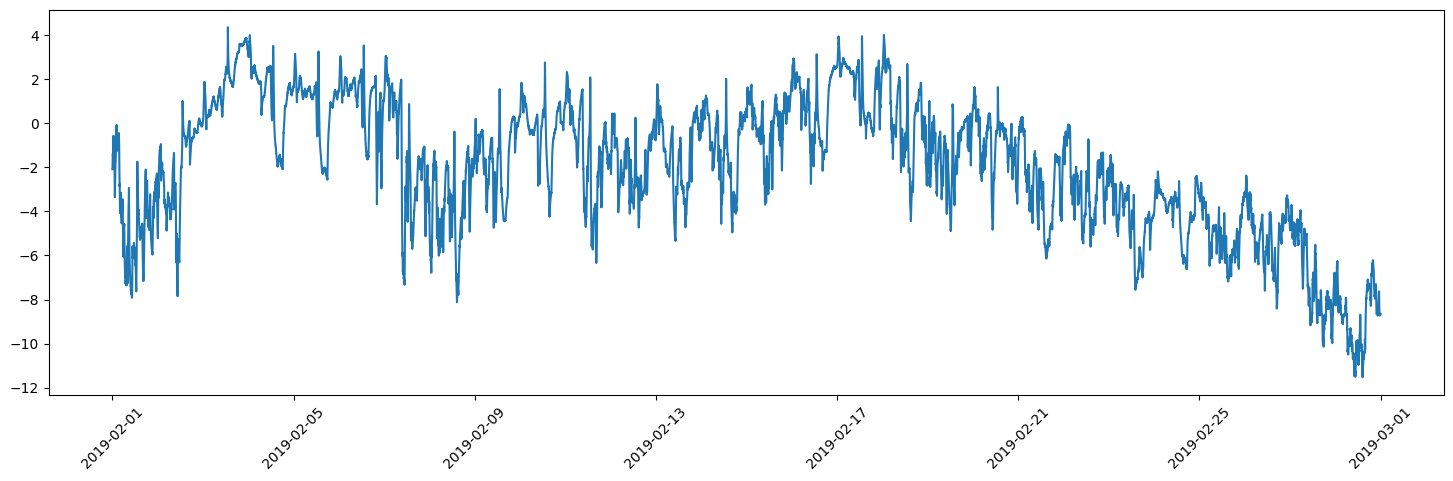

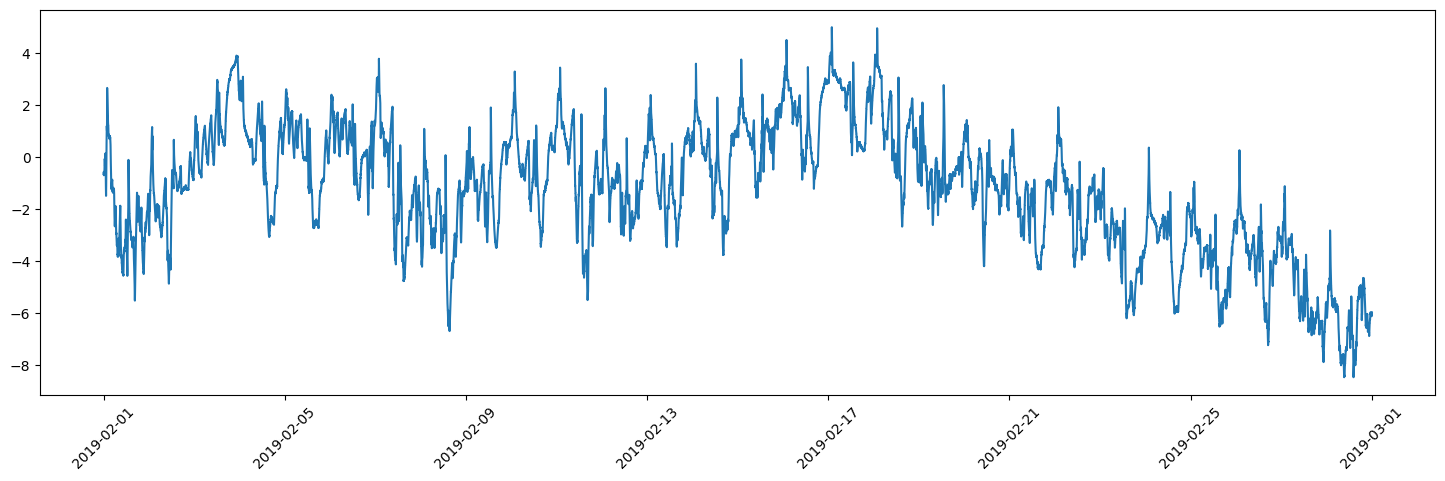

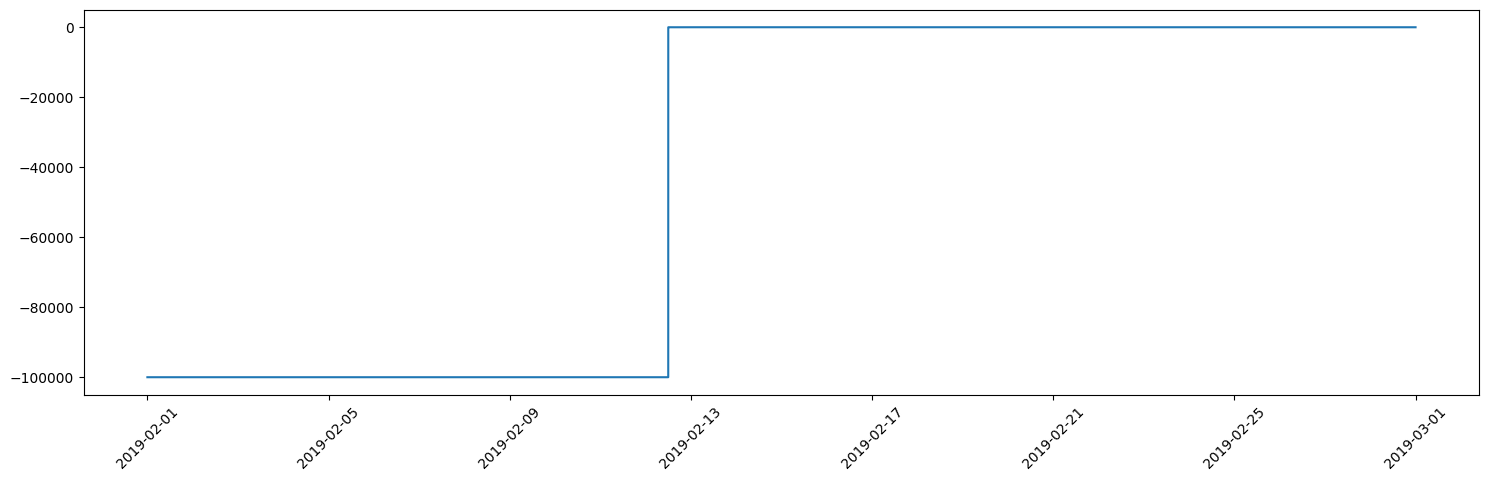

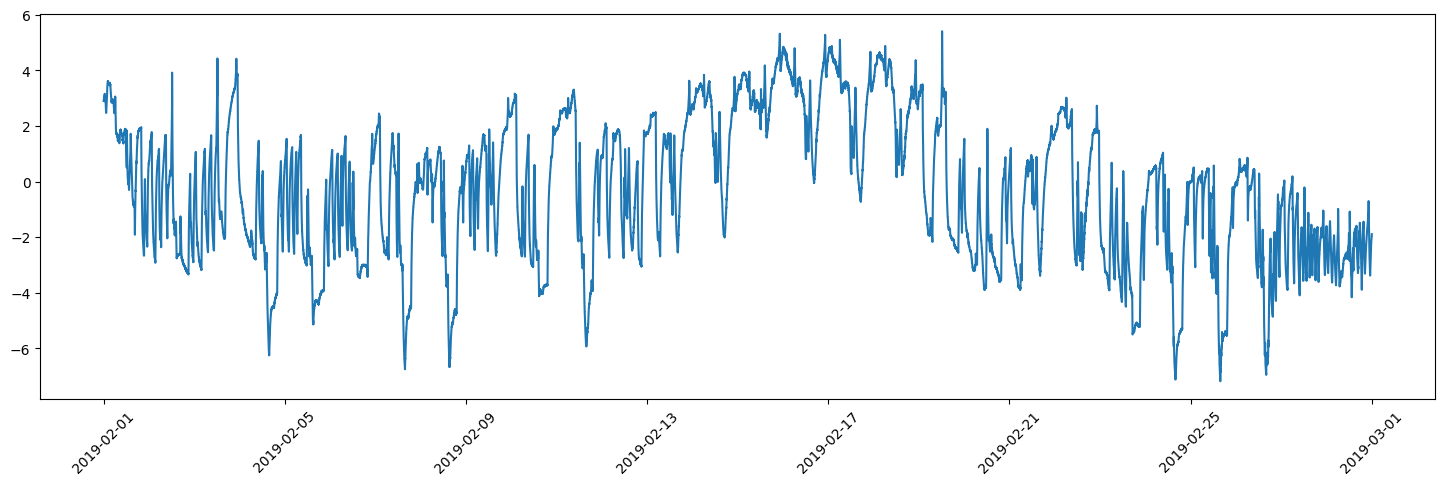

In [187]:
for _id in df_sensor['sensor_id'].unique():
    temp = df_sensor[df_sensor['sensor_id'] == _id]
    plt.figure(figsize=(18,5))
    plt.xticks(rotation = 45)
    plt.plot(temp['gw_time'], temp['temperature'], alpha = 1)

    plt.show()

In [ ]:

for _id in df_sensor['sensor_id'].unique():
    temp = df_sensor[df_sensor['sensor_id'] == _id]
    plt.figure(figsize=(18,5))
    plt.title('temperature of sensor {}'.format(_id))
    plt.xticks(rotation = 45)
    plt.plot(temp['gw_time'], temp['temperature'], alpha = 1)
    plt.show()
    for elem in df_freezer['freezer_id'].unique():
        tmp = df_freezer[df_freezer['freezer_id'] == elem]
        plt.figure(figsize=(18,5))
        plt.title('freezer {}'.format(elem))
        plt.xticks(rotation = 45)
        plt.ylabel('freez_run')
        plt.plot(tmp['gw_time'],tmp['freez_run'], alpha = 0.5)

 

# sensor 296, freezer 314 추출

In [145]:
test_s = df_sensor[df_sensor['sensor_id']== 296]
test_f = df_freezer[df_freezer['freezer_id']==314]

In [148]:
from tqdm import tqdm

# mapping
def time_mapping(freezer, sensor):
    # 키 생성
    freezer['key'] = [x for x in range(len(freezer))]
    sensor['key'] = [None]*len(sensor)

    # type 변환
    freezer = freezer.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)
    sensor = sensor.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)

    # sorting
    freezer['gw_time'] = pd.to_datetime(freezer['gw_time'])
    sensor['gw_time'] = pd.to_datetime(sensor['gw_time'])

    for i in tqdm(range(len(freezer)-1, -1, -1)):
        sensor.loc[(sensor['gw_time'] - freezer.loc[i,'gw_time'] <= dt.timedelta(seconds = 30))&(sensor['gw_time'] - freezer.loc[i,'gw_time'] > dt.timedelta(seconds = 0)), 'key'] = freezer.loc[i,'key']
    
    return sensor

test_s = time_mapping(test_f, test_s)



C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\562720427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freezer['key'] = [x for x in range(len(freezer))]
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\562720427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor['key'] = [None]*len(sensor)
100%|██████████| 81099/81099 [03:44<00:00, 361.95it/s]


In [210]:
df = pd.merge(test_f, test_s, how = 'outer', on = 'key')
df0 = df.drop(columns = ['fan_trip','freez_trip','defrost','ctrl_operation','color_list','insert_dt_x','insert_dt_y','freezer_id','sensor_id'])
col = ['key', 'gw_time_x', 'gw_time_y'] + [i for i in df0.columns if i not in ['key', 'gw_time_x', 'gw_time_y']]
df0 = df0[col]

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\1847219279.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(test_f, test_s, how = 'outer', on = 'key')


In [200]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df0['temperature'] = scaler.fit_transform(df0['temperature'].values.reshape(-1,1))
df0['avg_temperature'] = scaler.fit_transform(df0['avg_temperature'].values.reshape(-1,1))
df0['humidity'] = scaler.fit_transform(df0['humidity'].values.reshape(-1,1))
df0['avg_humidity'] = scaler.fit_transform(df0['avg_humidity'].values.reshape(-1,1))


C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\3627037836.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df0.corr(method= 'pearson')


<AxesSubplot: >

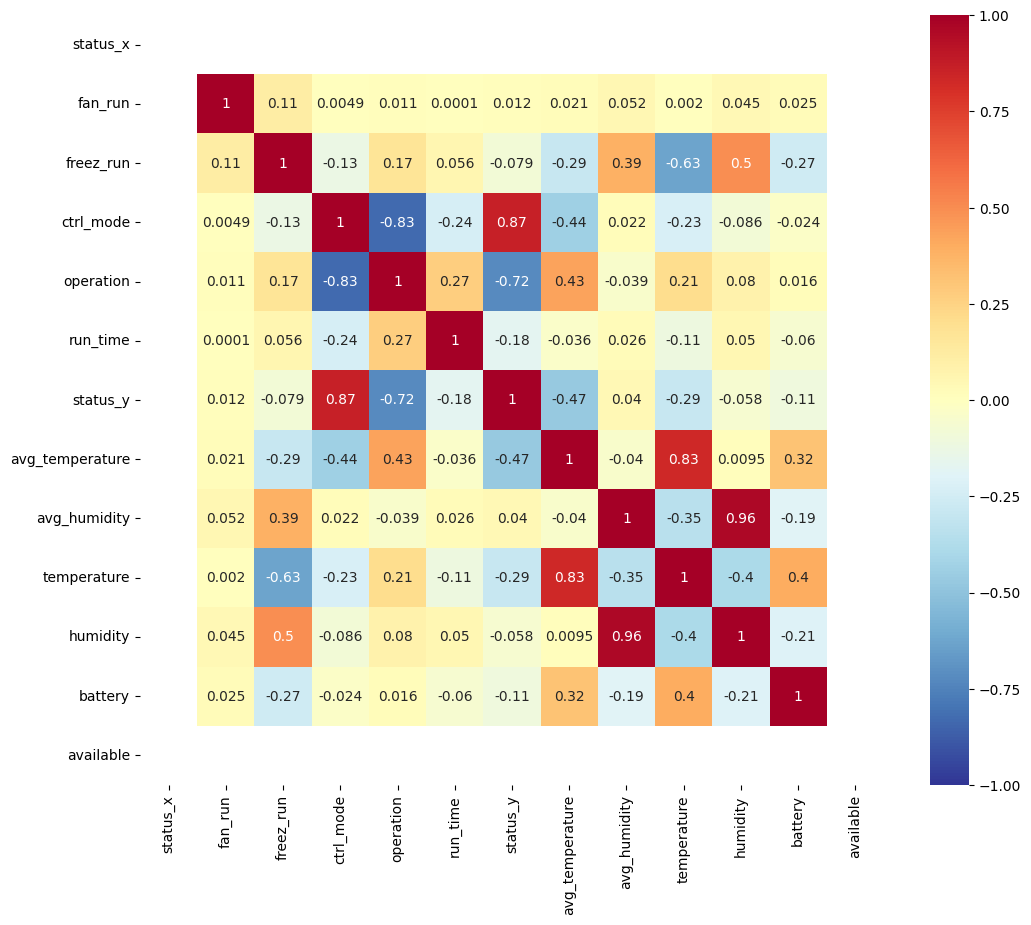

In [218]:
import seaborn as sns
df = df0.corr(method= 'pearson')
plt.figure(figsize= (12,10))
sns.heatmap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\2037606350.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df0.corr(method= 'spearman')


<AxesSubplot: >

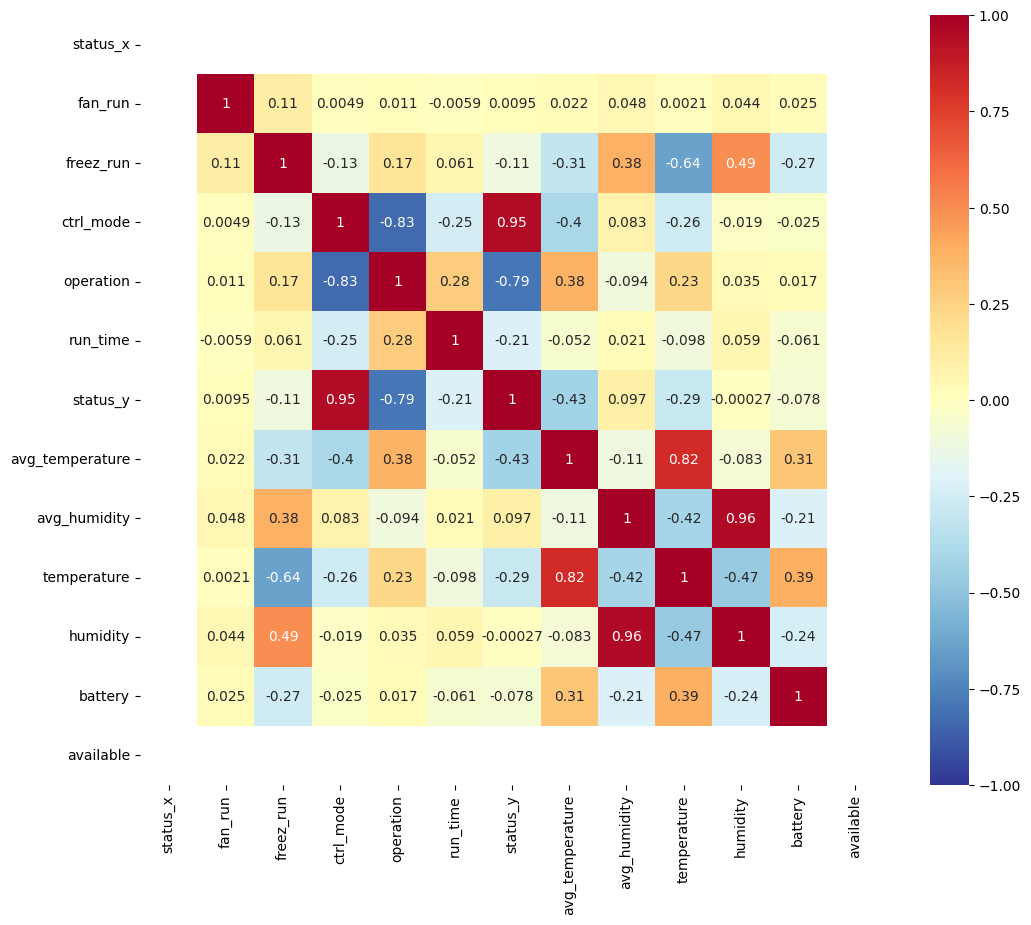

In [219]:
import seaborn as sns
df = df0.corr(method= 'spearman')
plt.figure(figsize= (12,10))
sns.heatmap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [214]:
df0.corr(method = 'spearman')['temperature'].sort_values()

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\56761950.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df0.corr(method = 'spearman')['temperature'].sort_values()


freez_run         -0.638428
humidity          -0.474787
avg_humidity      -0.420627
status_y          -0.289663
ctrl_mode         -0.258028
run_time          -0.097697
fan_run            0.002113
operation          0.232608
battery            0.394972
avg_temperature    0.816074
temperature        1.000000
status_x                NaN
available               NaN
Name: temperature, dtype: float64

In [215]:
df0.corr(method = 'pearson')['temperature'].sort_values()

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\2128141552.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df0.corr(method = 'pearson')['temperature'].sort_values()


freez_run         -0.632729
humidity          -0.398366
avg_humidity      -0.350173
status_y          -0.289728
ctrl_mode         -0.234010
run_time          -0.112919
fan_run            0.001953
operation          0.209405
battery            0.403857
avg_temperature    0.831397
temperature        1.000000
status_x                NaN
available               NaN
Name: temperature, dtype: float64

In [157]:
test_f

,freezer_id,gw_time,status,fan_run,fan_trip,freez_run,freez_trip,defrost,ctrl_mode,ctrl_operation,operation,run_time,insert_dt,key
2,314,2019-02-01 00:00:19,1,1.0,0.0,0.0,0.0,0.0,0,1,1,0,2019-02-01 00:00:19,0
5,314,2019-02-01 00:00:49,1,1.0,0.0,0.0,0.0,0.0,0,1,1,0,2019-02-01 00:00:50,1
9,314,2019-02-01 00:01:19,1,1.0,0.0,0.0,0.0,0.0,0,1,1,1,2019-02-01 00:01:20,2
13,314,2019-02-01 00:01:50,1,1.0,0.0,0.0,0.0,0.0,0,1,1,1,2019-02-01 00:01:50,3
17,314,2019-02-01 00:02:20,1,1.0,0.0,0.0,0.0,0.0,0,1,1,2,2019-02-01 00:02:20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324378,314,2019-02-28 23:57:35,1,1.0,0.0,0.0,0.0,0.0,1,0,0,0,2019-02-28 23:57:35,81094
324381,314,2019-02-28 23:58:05,1,1.0,0.0,0.0,0.0,0.0,1,0,0,0,2019-02-28 23:58:05,81095
324387,314,2019-02-28 23:58:35,1,1.0,0.0,0.0,0.0,0.0,1,0,0,0,2019-02-28 23:58:35,81096
324390,314,2019-02-28 23:59:05,1,1.0,0.0,0.0,0.0,0.0,1,0,0,0,2019-02-28 23:59:05,81097


# sensor 296, freezer 308 추출 (센서는 같고 freezer 바꿔봄)

In [220]:
test_s = df_sensor[df_sensor['sensor_id']== 296]
test_f = df_freezer[df_freezer['freezer_id']==308]

In [221]:
from tqdm import tqdm

# mapping
def time_mapping(freezer, sensor):
    # 키 생성
    freezer['key'] = [x for x in range(len(freezer))]
    sensor['key'] = [None]*len(sensor)

    # type 변환
    freezer = freezer.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)
    sensor = sensor.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)

    # sorting
    freezer['gw_time'] = pd.to_datetime(freezer['gw_time'])
    sensor['gw_time'] = pd.to_datetime(sensor['gw_time'])

    for i in tqdm(range(len(freezer)-1, -1, -1)):
        sensor.loc[(sensor['gw_time'] - freezer.loc[i,'gw_time'] <= dt.timedelta(seconds = 30))&(sensor['gw_time'] - freezer.loc[i,'gw_time'] > dt.timedelta(seconds = 0)), 'key'] = freezer.loc[i,'key']
    
    return sensor

test_s = time_mapping(test_f, test_s)



C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\562720427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freezer['key'] = [x for x in range(len(freezer))]
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\562720427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor['key'] = [None]*len(sensor)
100%|██████████| 81099/81099 [03:59<00:00, 338.25it/s]


In [222]:
df = pd.merge(test_f, test_s, how = 'outer', on = 'key')
df0 = df.drop(columns = ['fan_trip','freez_trip','defrost','ctrl_operation','color_list','insert_dt_x','insert_dt_y','freezer_id','sensor_id'])
col = ['key', 'gw_time_x', 'gw_time_y'] + [i for i in df0.columns if i not in ['key', 'gw_time_x', 'gw_time_y']]
df0 = df0[col]

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\1847219279.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(test_f, test_s, how = 'outer', on = 'key')


In [225]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df0['temperature'] = scaler.fit_transform(df0['temperature'].values.reshape(-1,1))
df0['avg_temperature'] = scaler.fit_transform(df0['avg_temperature'].values.reshape(-1,1))
df0['humidity'] = scaler.fit_transform(df0['humidity'].values.reshape(-1,1))
df0['avg_humidity'] = scaler.fit_transform(df0['avg_humidity'].values.reshape(-1,1))


C:\Users\Intellicode\AppData\Local\Temp\ipykernel_9528\3627037836.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df0.corr(method= 'pearson')


<AxesSubplot: >

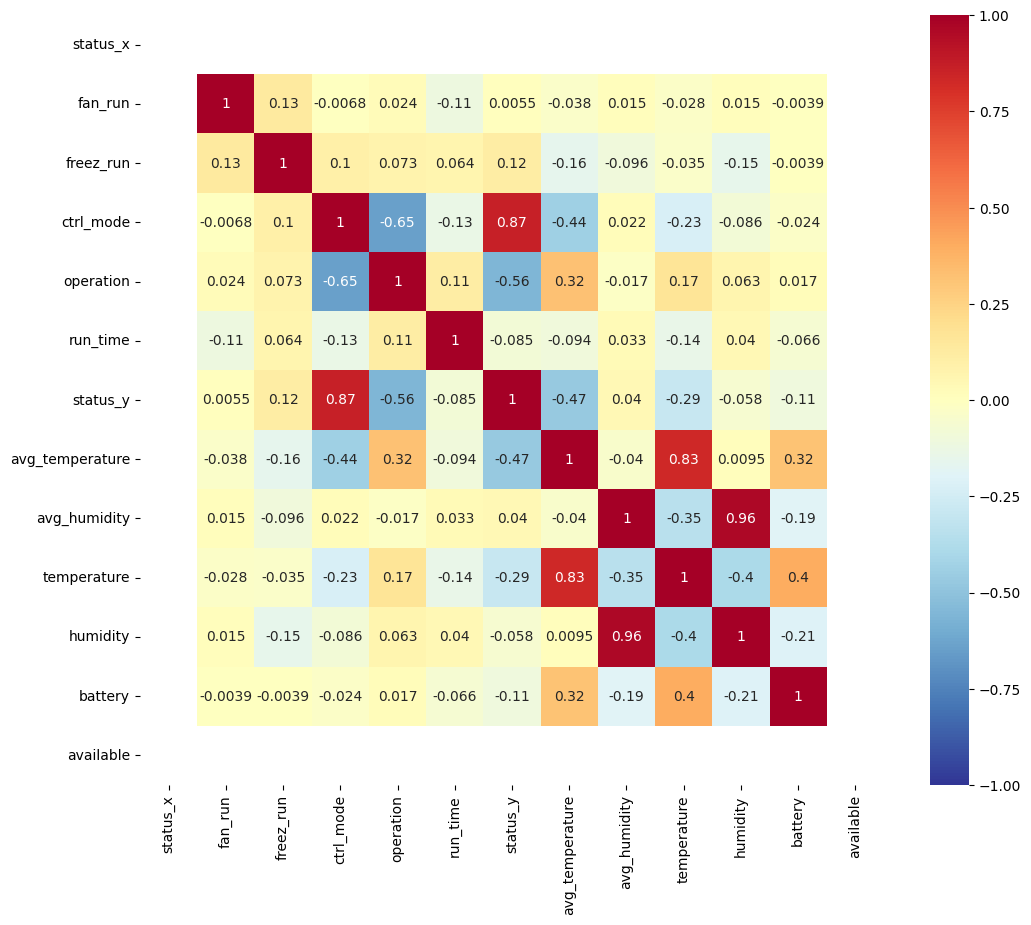

In [224]:
import seaborn as sns
df = df0.corr(method= 'pearson')
plt.figure(figsize= (12,10))
sns.heatmap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [248]:
sensor_pos = {
    "290": {"x": 2, "y": 3},
    "293": {"x": 5, "y": 3},
    "296": {"x": 3, "y": 8},
    "299": {"x": 4, "y": 14},
    "302": {"x": 4, "y": 5}
}
freezer_pos = {
    "308": {"x": 2, "y": 1},
    "314": {"x": 6, "y": 1},
    "320": {"x": 8, "y": 10},
    "326": {"x": 4, "y": 17}
}

sensor_pos = pd.DataFrame(sensor_pos).T
freezer_pos = pd.DataFrame(freezer_pos).T

In [249]:
sensor_pos = sensor_pos.reset_index()
freezer_pos = freezer_pos.reset_index()
pos = pd.concat([sensor_pos,freezer_pos])


Text(6, 4, '314(freezer)')

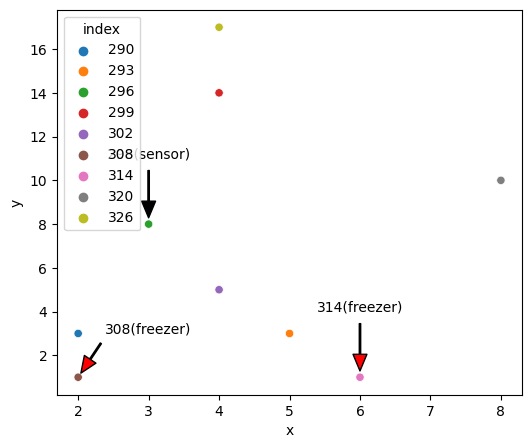

In [265]:
plt.figure(figsize = (6,5))
sns.scatterplot(x = 'x', y = 'y', data = pos, hue = 'index')
plt.annotate('296(sensor)', xy=(3, 8), xytext=(3,11),
            fontsize=10, ha='center',
            arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))

plt.annotate('308(freezer)', xy=(2, 1), xytext=(3,3),
            fontsize=10, ha='center',
            arrowprops=dict(facecolor='red', width=1, shrink=0.1, headwidth=10))

plt.annotate('314(freezer)', xy=(6, 1), xytext=(6,4),
            fontsize=10, ha='center',
            arrowprops=dict(facecolor='red', width=1, shrink=0.1, headwidth=10))
        